## Brainstorming
#### Analysis Questions 
- How many temperature readings in each month seemed inaccurate
    - I defined the outliers as being 2 standard deviations above or below the mean

#### Data Quality Assessment
- **First**:
    - Renaming all the columns to a shorter, simplified name
    - Needing to use `FAWN_raw.columns = FAWN_raw.columns.str.strip()` to make all the white spaces between letters, numbers, or symbols single spaces so all the spaces are uniform  
- Check data types using `.info()`
    - displays: Column names, types, non-null counts, memory
- Check statistical description using `.describe()`  
- Use `.value_counts()` for frequency count of each category (**need to do**)
- Finding outliers for max and min temperatures   
    - find `std()` for max and min temperatures, by month, for all three years using `groupby()`  



## EDA Workflow


### Load and Initial Reconnaissance


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# loading Dataset from a CSV file #
FAWN_raw_initial = pd.read_csv("data/FAWN_report.csv")
FAWN_raw = pd.read_csv("data/FAWN_report.csv", parse_dates=["Period"], date_format="%d-%b-%y")
FAWN_clean = FAWN_raw
# FAWN_raw_spaces = FAWN_raw.columns.tolist()

# Cleaning spaces in raw data set
FAWN_clean.columns = FAWN_raw.columns.str.replace("  ", " ")

# Quality Assessment
FAWN_clean.describe()
FAWN_clean_loc_counts = FAWN_clean['FAWN Station'].value_counts()
FAWN_clean_loc = FAWN_clean['FAWN Station'].unique()
print(f"\n{FAWN_clean.dtypes}\n{FAWN_clean.info()}\n\n{FAWN_clean_loc_counts}\n")
print(f"{FAWN_clean_loc}\n\nThere are {len(FAWN_clean_loc)} weather stations represented in this DataFrame.\n")
print(f"Shape/dimensions of DataFrame: {FAWN_clean.shape}\n")
print(f"Number of Elements: {FAWN_clean.size}\n")

FAWN_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6572 entries, 0 to 6571
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   FAWN Station                 6572 non-null   object        
 1   Period                       6572 non-null   datetime64[ns]
 2   2m T avg (F)                 6572 non-null   float64       
 3   2m T min (F)                 6572 non-null   float64       
 4   2m T max (F)                 6572 non-null   float64       
 5   2m DewPt avg (F)             6572 non-null   float64       
 6   RelHum avg 2m (pct)          6572 non-null   int64         
 7   2m Rain tot (in)             6572 non-null   float64       
 8   2m Rain max over 15min (in)  6572 non-null   float64       
 9   SolRad avg2m (w/m^2)         6572 non-null   float64       
 10  10m Wind avg (mph)           6572 non-null   float64       
 11  10m Wind min (mph)           6572 non-null 

,FAWN Station,Period,2m T avg (F),2m T min (F),2m T max (F),2m DewPt avg (F),RelHum avg 2m (pct),2m Rain tot (in),2m Rain max over 15min (in),SolRad avg2m (w/m^2),10m Wind avg (mph),10m Wind min (mph),10m Wind max (mph),WDir avg10m (deg),BP avg (mb),N (# obs),2m WetBulb (F)
0,Apopka,2022-01-01,73.40,66.40,82.40,65.34,78,0.00,0.00,156.50,4.29,0.00,17.83,196,1014,96,67.97
1,Apopka,2022-01-02,73.41,67.06,81.93,68.16,84,0.00,0.00,124.04,5.42,0.13,18.36,221,1013,96,69.80
2,Apopka,2022-01-03,61.63,47.97,71.69,50.10,68,0.03,0.03,178.06,9.36,0.43,28.50,309,1016,96,55.06
3,Apopka,2022-01-04,58.21,43.94,72.05,51.42,80,0.00,0.00,144.97,5.12,0.05,16.96,39,1019,96,54.32
4,Apopka,2022-01-05,62.97,54.84,74.03,58.64,87,0.00,0.00,116.53,4.12,0.02,14.23,353,1014,96,60.27


#### Analysis worth exploring (can subtract from if needed)
- The following columns could answer my questions:
  - minimum and maximum temperature (F)
  - dew point, relative humidity
  - maximum rainfall
  - minimum and maximum wind (mph)
  - wind direction (deg)
  - number of observations
- How many temperature readings in each month seemed inaccurate or could be classified as outliers?



### Data Quality Assessment 
- The column names were in a scattered format and hard to read:
    - Renamed the columns to a more readable format
- The `N (# obs)` column could be worth exploring for accuracy purposes
- All of the `dtypes` displayed above are accurate, and the DataFrame appears not to have any NaN values when comparing the result of `dtypes` to the `shape` of the DataFrame
- Used `groupby()` to separate the min temp by month and then used `quantile(0.5)`, which finds the temperature that 50% of the temperatures are above and below
- The columns: `2m Rain tot (in)` and `2m Rain max over 15min (in)` contain some values of 0
    - The count of these values can be found using `isin()` 
- Outliers can be determined with `between()`
  - could use by month 

In [92]:
FAWN_clean['N (# obs)'].unique()

#FAWN_clean['FAWN Station'].between()
# Grouping min temp by month to find quantile %s
FAWN_clean['Month'] = FAWN_clean['Period'].dt.month_name() 
#FAWN_clean['2m T min (F)'].quantile(0.5)
monthyly_T_min = FAWN_clean.groupby('Month')['2m T min (F)']
monthyly_T_min.quantile(0.5) 

zero_rain_Monthcount = FAWN_clean[FAWN_clean['2m Rain tot (in)'] == 0].groupby(['Month', 'FAWN Station']).size().unstack()
print(f"\nNumber of non-rainy days categorized by month: \n\n{zero_rain_Monthcount}\n")

rain_Monthcount = FAWN_clean[FAWN_clean['2m Rain tot (in)'] != 0].groupby(['Month', 'FAWN Station']).size().unstack()
print(f"\nNumber of rainy days categorized by month: \n\n{rain_Monthcount}\n") 

non_rainyDays = FAWN_clean[FAWN_clean['2m Rain tot (in)'].isin([0])]
rainyDays = FAWN_clean[~FAWN_clean['2m Rain tot (in)'].isin([0])]
print(f"\nNumber of rainy days: {len(rainyDays['2m Rain tot (in)'])}\n")
print(f"Number of non-rainy days: {len(non_rainyDays['2m Rain tot (in)'])}\n")



Number of non-rainy days categorized by month: 

FAWN Station  Apopka  DeFuniak Springs  Homestead  Jay  Live Oak  Monticello
Month                                                                       
April             69                61         65   65        62          63
August            41                52         35   60        47          42
December          68                59         66   63        71          75
February          67                64         66   59        65          64
January           65                56         64   57        64          57
July              37                39         36   32        36          39
June              51                53         26   47        51          58
March             69                66         71   60        63          59
May               63                64         56   56        58          66
November          61                61         66   56        66          62
October           71      

In [70]:

FAWN_clean.rename(
    columns={
        "2m T avg (F)": "Temp_avg (F)",
        "2m T min (F)": "T_min (F)",
        "2m T max (F)": "T_max (F)",
        "2m DewPt avg (F)": "DewPt_avg (F)",
        "RelHum avg 2m (pct)": "RelHum_avg (pct)",
        "2m Rain tot (in)": "Rain_tot (in)",
        "2m Rain max over 15min (in)": "Rain_max over 15min (in)",
        "SolRad avg2m (w/m^2)": "SolRad_avg @ 2m (w/m^2)",
        "10m Wind avg (mph)": "Wind_avg @ 10m (mph)",
        "10m Wind min (mph)": "Wind_min @ 10m (mph)",
        "10m Wind max (mph)": "Wind_max @ 10m (mph)",
        "WDir avg10m (deg)": "Wind_Dir_avg @ 10m (deg)",
        "BP avg (mb)": "Barametric_Pre_avg (mb)",
        "N (# obs)": "N (#obs)",
        "2m WetBulb (F)": "WetBulb @ 2m (F)",
    },
    inplace=True,
)


# FAWN_raw = FAWN_raw.replace('0', np.nan)
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

# print(f"{FAWN_clean.isna().sum()}\n")

# print(f"{FAWN_raw_spaces}\n")
# print(f"{FAWN_raw.columns}\n")


# print(f"Number of Elements: {FAWN_clean['Period'].dt.month}

# Finding min temp outliers by month
FAWN_clean["Month"] = FAWN_clean["Period"].dt.month_name()
monthyly_std_T_min = FAWN_clean.groupby("Month")["T_min (F)"].std() * 2
monthyly_mean_T_min = FAWN_clean.groupby("Month")["T_min (F)"].mean()
print(f"Two times Std: \n{monthyly_std_T_min}\n")
print(f"Mean of each month: \n{monthyly_mean_T_min}\n")

# Creating a separate column for Days
FAWN_clean["Day"] = FAWN_clean["Period"].dt.day_name()
# daily_T_min_byMonth = FAWN_clean.groupby('Month').agg({'Day':

# Calculating two std dev values above and below the mean for each month
two_std_overMean = monthyly_std_T_min + monthyly_mean_T_min
two_std_underMean = monthyly_mean_T_min - monthyly_std_T_min
print(f"Two std above Mean: \n{two_std_overMean}\n")
print(f"Two std below Mean: \n{two_std_underMean}\n")

"""FAWN_clean.merge(
    two_std_underMean.rename('Two std above Temp_min Mean'), 
    left_on=FAWN_clean['Month'], 
    right_index=True, 
    how='left'
)"""

# Adding two std dev values above and below the mean for each month
FAWN_clean["Two std above Temp_min Mean"] = FAWN_clean["Month"].map(two_std_overMean)
FAWN_clean["Two std below Temp_min Mean"] = FAWN_clean["Month"].map(two_std_underMean)

# Setting Period as index
FAWN_clean = FAWN_clean.set_index("Period")

# Finding Outliers
Temp_min_outlier = FAWN_clean[
    (FAWN_clean["T_min (F)"] > FAWN_clean["Two std above Temp_min Mean"])
    | (FAWN_clean["T_min (F)"] < FAWN_clean["Two std below Temp_min Mean"])
]
# print(Temp_min_outlier.count())

FAWN_clean.groupby()
#print(f"\nNumber of outliers: \n{Temp_min_outlier['T_min (F)']}")

Two times Std: 
Month
April        15.279022
August        7.162487
December     24.807597
February     21.850377
January      24.582958
July          3.938732
June          6.738043
March        19.963387
May          10.419026
November     22.793263
October      18.824179
September    10.031553
Name: T_min (F), dtype: float64

Mean of each month: 
Month
April        58.820389
August       73.427527
December     48.263817
February     50.020529
January      45.547545
July         73.746882
June         71.184648
March        55.189427
May          66.217634
November     56.160815
October      59.633871
September    69.888722
Name: T_min (F), dtype: float64

Two std above Mean: 
Month
April        74.099411
August       80.590015
December     73.071414
February     71.870907
January      70.130502
July         77.685614
June         77.922691
March        75.152814
May          76.636660
November     78.954078
October      78.458050
September    79.920275
Name: T_min (F), dtype: float6

TypeError: You have to supply one of 'by' and 'level'

#### Histogram of Minimum Temp values **by** month
- Graph the minimum temperature value for each day by month
- Should give you 12 graphs 
    - Label two std deviations above **and** below the mean on **each** graph 
- `Temp_min_outlier = FAWN_clean[ (FAWN_clean["T_min (F)"] > FAWN_clean["Two std above Temp_min Mean"])
    | (FAWN_clean["T_min (F)"] < FAWN_clean["Two std below Temp_min Mean"])]`
    - Try to use this variable, `Temp_min_outlier`, to highlight the outliers on the graph 


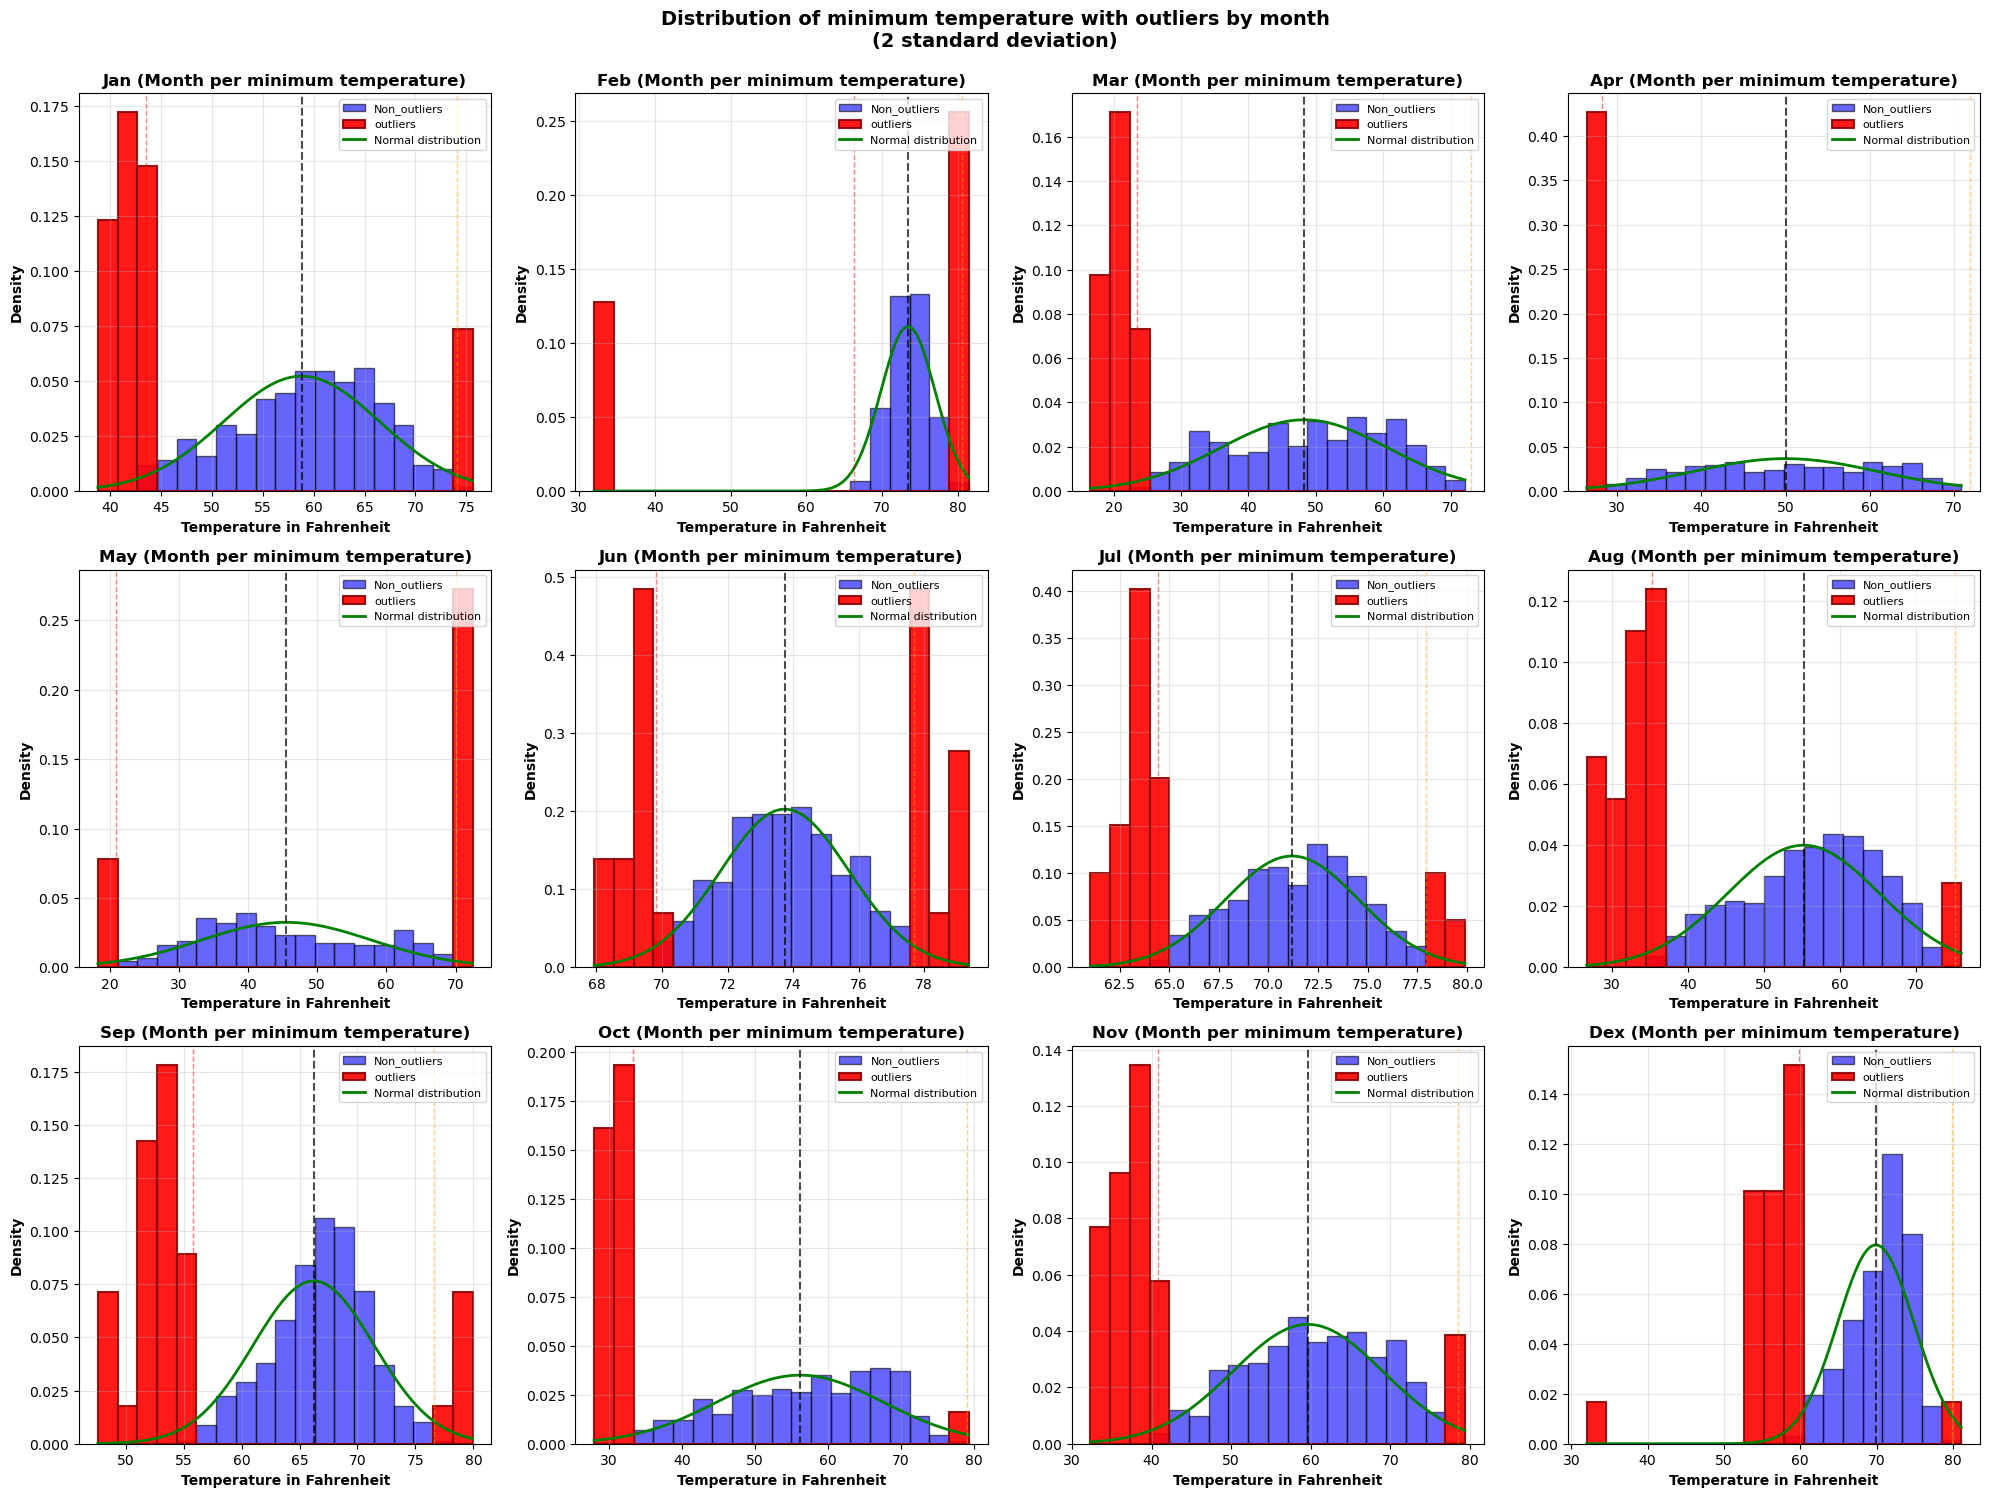

In [2]:
# To create a column for the Temp_min_outlier for the entire dataset
# calculate the 2 standard deviation boundaries for each month
monthly_stat = FAWN_clean.groupby("Month")["T_min (F)"].agg(["mean", "std"]).reset_index()
monthly_stat["upper_bound"] = monthly_stat["mean"] + 2 * monthly_stat["std"]
monthly_stat["lower_bound"] = monthly_stat["mean"] - 2 * monthly_stat["std"]

# Let merge with the dataFrame
FAWN_clean = FAWN_clean.merge(
    monthly_stat[["Month", "upper_bound", "lower_bound"]],
    on="Month",
    how="left",
    suffixes=("", "_monthly"),
)

# finally, let us create the outlier column
FAWN_clean["Temp_min_outlier"] = (FAWN_clean["T_min (F)"] > FAWN_clean["upper_bound"]) | (
    FAWN_clean["T_min (F)"] < FAWN_clean["lower_bound"]
)


# To create the subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# To get unique months
months = FAWN_clean["Month"].unique()
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dex"]

# Now let's loop through each month
for idx, month in enumerate(sorted(months)):
    ax = axes[idx]

    # Filter data for this month
    month_data = FAWN_clean[FAWN_clean["Month"] == month].copy()

    # To get the temperature data
    temp_data = month_data["T_min (F)"].dropna()

    # To identify the outliers, i.e, values outside the 2 std from the mean
    outliers = month_data[month_data["Temp_min_outlier"] == True]["T_min (F)"].dropna()
    Non_outliers = month_data[month_data["Temp_min_outlier"] == False]["T_min (F)"].dropna()

    # To calculate the statistics
    mean_temp = temp_data.mean()
    std_temp = temp_data.std()

    # Now, let's create bins
    if len(temp_data) > 0:
        bin_edges = np.linspace(temp_data.min(), temp_data.max(), 20)

        # histogram plots for non-outliers and outliers
        ax.hist(
            Non_outliers,
            bins=bin_edges,
            alpha=0.6,
            color="blue",
            label="Non_outliers",
            density=True,
            edgecolor="black",
        )
        if len(outliers) > 0:
            ax.hist(
                outliers,
                bins=bin_edges,
                alpha=0.9,
                color="red",
                label="outliers",
                density=True,
                edgecolor="darkred",
                linewidth=1.5,
            )

            # let add normal distribution curve
            x = np.linspace(temp_data.min(), temp_data.max(), 100)
            normal_curve = stats.norm.pdf(x, mean_temp, std_temp)
            ax.plot(x, normal_curve, "green", linewidth=2, label="Normal distribution")

            # Let's add a vertical line for the mean
            ax.axvline(mean_temp, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

            # Define the outliers and non-outliers
            upper_bound = mean_temp + 2 * std_temp
            lower_bound = mean_temp - 2 * std_temp
            ax.axvline(upper_bound, color="orange", linestyle="--", linewidth=1, alpha=0.5)
            ax.axvline(lower_bound, color="red", linestyle="--", linewidth=1, alpha=0.5)

        # Let label and give title to the plot's
        ax.set_xlabel("Temperature in Fahrenheit", fontsize=10, fontweight="bold")
        ax.set_ylabel("Density", fontsize=10, fontweight="bold")
        ax.set_title(
            f"{month_names[idx]} (Month per minimum temperature)", fontsize=12, fontweight="bold"
        )
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle(
    "Distribution of minimum temperature with outliers by month\n(2 standard deviation)",
    fontsize=14,
    fontweight="bold",
    y=0.995,
)

plt.tight_layout()
plt.show()